# Who is the best Formula 1 driver of all time?

### Table of contents
1. Feature engineering
2. Ridge regression
3. Linear GAM
4. Logistic GAM
    1. Base model
    2. Tuning lambda values
    3. Competition effect
5. Model comparison
6. Conclusion and next steps

Formula 1 has always been a difficult sport to assess from a statistical perspective. Although teams have huge amounts of data to work with (and undoubtedly are doing so), practically none of it is publicly accessible. Additionally, Formula 1 is and always has been an engineering competition first, and a driving competition second, a fact that is often forgotten by fans of the sport. The speed of competing cars in any given season can vary drastically, which greatly restricts our ability to easily assess driver talent. In other sports such as basketball or soccer, we can at least be assured that the playing field is relatively even. However, in Formula 1 we can only compare drivers to those who drive the same car as them - their teammates, which significantly lessens the number of comparisons that we can perform for each driver, not helped by the fact that for much of Formula 1's history, each team only fielded a pair of drivers at any given race. It is with this approach that we attempt to derive a driver's true talent level independent of factors that are outside their control.

We will be assessing a few candidate models, as detailed below.

In [2]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pygam import LinearGAM, GAM, LogisticGAM, s, f, l, te

import f1_rating_model_functions as func
import imp
imp.reload(func)

ModuleNotFoundError: No module named 'statsmodels'

The data is supplied by Ergast, the most popular source of Formula 1 data. The data comes cleaned in several .csv files which mostly eliminates the need for EDA.

In [2]:
results=pd.read_csv("H:\Random files\Data analyst/f1/f1 rating model/raw/results.csv")
races=pd.read_csv("H:\Random files\Data analyst/f1/f1 rating model/raw/races.csv")
drivers=pd.read_csv("H:\Random files\Data analyst/f1/f1 rating model/raw/drivers.csv")
constructors=pd.read_csv("H:\Random files\Data analyst/f1/f1 rating model/raw/constructors.csv")
status=pd.read_csv("H:\Random files\Data analyst/f1/f1 rating model/raw/status.csv")

## 1. Feature engineering

In [3]:
# merging tables

results_concat=results.merge(races, how='left', on='raceId')
results_concat=results_concat.merge(drivers, how='left', on='driverId')
results_concat=results_concat.merge(constructors, how='left', on='constructorId')
results_concat=results_concat.merge(status, how='left', on='statusId')

results_concat['driver_name']=results_concat['forename']+" "+results_concat['surname']
results_concat=results_concat.rename({'name_x':'race_name', 'name_y':'constructor_name'}, axis=1)
results_concat['constructor_year']=results_concat['year'].astype('str')+" "+results_concat['constructor_name']
results_concat=results_concat.loc[results_concat['race_name']!='Indianapolis 500',:]

results_concat=results_concat[[
    'year',
    'round',
    'date',
    'race_name',
    'driver_name',
    'dob',
    'constructor_year',
    'positionOrder',
    'status',
    'laps'
]]

results_concat.head(3)

,year,round,date,race_name,driver_name,dob,constructor_year,positionOrder,status,laps
0,2008,1,2008-03-16,Australian Grand Prix,Lewis Hamilton,1985-01-07,2008 McLaren,1,Finished,58
1,2008,1,2008-03-16,Australian Grand Prix,Nick Heidfeld,1977-05-10,2008 BMW Sauber,2,Finished,58
2,2008,1,2008-03-16,Australian Grand Prix,Nico Rosberg,1985-06-27,2008 Williams,3,Finished,58


In order to distinguish between the skill of a driver and the speed of his/her machinery, dummy variables must be created for each driver and constructor. Since constructors design a car for each competition year, it is necessary to create dummies for each unique *constructor-year pair*. This results in well over a thousand additional features with perfect multicollinearity, which necessitates the use of some kind of regularization method. Ridge regression is chosen over Lasso due to its suitability to dealing with the multicollinearity issue as well as the fact that it does not perform feature selection (we need a coefficient for all drivers and constructor-year pairs).

The driver's age and years of recent experience are also taken into consideration. The latter distinction is important as drivers often taken breaks, most notably Michael Schumacher's sabbatical from 2007-9, which affects their performance on their return. Models that do not account for this issue struggle to reconcile the relationships between certain drivers, such as Schumacher's performance against Nico Rosberg from 2010-12.

One more important issue to consider is the choice of the dependent variable. Common choices include points scored and finishing position, the latter of which is used in this model. Ultimately, the issue boils down to what system is more representative of the differences in outcomes between drivers. All point scoring systems that have ever been used are biased in favor of the top positions as the amount of points a driver receives decreases exponentially as they tumble down the order. Using finishing position at the very least creates a linear relationship between finishing position and 'performance'. Ideally we could use finishing time, but there are too many additional factors to consider like safety cars and weather, and data quality is poor for any year before the modern era.

Other more minor considerations:
* Only drivers with 5 or more counting races were included. A 'counting' race is one in which the driver does not suffer a non-driver-related DNF. This is to prevent potential outliers from skewing the results.
* For the ridge regression model which is unable to determine a more non-linear relationship for age, an alternative feature is engineered to try and simulate a more linear relationship (years from prime).
* Many of the drivers who in the initial years of F1 were not rookies, as they had years of experience in grand prix racing prior to the official creation of F1 in 1950. Thus, years of experience for drivers in the early years of F1 had to be manually collected from their Wikipedia pages. My own judgement as to what constituted relevant experience was used, which leads to some unavoidable degree of human error in the model.

In [4]:
# classifying finish status
results_full=results_concat.copy()
results_full.loc[results_full['status'].str.contains('Finished|Lap'), 'dnf']=0
results_full['dnf']=results_full['dnf'].fillna(1)
results_full.loc[results_full['status'].str.contains('Accident|Collision|Spun'), 'status']='retired_human_error'
results_full.loc[(~(results_full['status'].str.contains('retired_human_error')))&(~(results_full['status'].str.contains('Finished|Lap'))),'status']='retired_technical_error'
results_full.loc[results_full['status'].str.contains('Finished|Lap'), 'status']='finished'

# creating technical problems dummy variable
#results_full.loc[results_full['status']=='retired_technical_error', 'technical_problems']=1
#results_full['technical_problems']=results_full['technical_problems'].fillna(0)

# creating human error dummy variable
#results_full.loc[results_full['status']=='retired_human_error', 'human_error']=1
#results_full['human_error']=results_full['human_error'].fillna(0)

# determining % race not completed
results_full=results_full.merge(results_full.groupby(['year', 'round']).max(['laps'])['laps'].reset_index(), how='left', on=['year', 'round'])
results_full['race%_not_completed']=1-results_full['laps_x']/results_full['laps_y']
results_full.loc[results_full['status']=='finished', 'race%_not_completed']=0
results_full=results_full.drop(['laps_x', 'laps_y'], axis=1)

# determining number of drivers in each race
results_full=results_full.merge(results_full.loc[results_full['status']=='finished', :].groupby(['year', 'race_name']).agg('count')['round'].reset_index(), on=['year', 'race_name'], how='left')
results_full=results_full.merge(results_full.groupby(['year', 'race_name']).agg('count')['round_x'].reset_index(), on=['year', 'race_name'], how='left', suffixes=(None, '_x'))
results_full=results_full.rename({'round_x':'round', 'round_y':'num_finishing_drivers', 'round_x_x':'num_drivers'}, axis=1)
results_full['finish_ratio']=results_full['num_finishing_drivers']/results_full['num_drivers']
#results_full['dnf_ratio']=(results_full['num_drivers']-results_full['num_finishing_drivers'])/results_full['num_drivers']

# filtering out drivers with less than 5 total finishes
min_races_filter=results_full.loc[~(results_full['status']=='retired_technical_error'), :]
min_races_filter=min_races_filter.groupby(['driver_name']).size().reset_index(name='count').sort_values('count', ascending=False)
min_races_filter=min_races_filter.loc[min_races_filter['count']>=5, :]

results_full=results_full.merge(min_races_filter['driver_name'], how='inner', on='driver_name')

# determining years of experience, capped at 4
pre_1950_drivers=pd.read_csv("H:\Random files\Data analyst/f1/f1 rating model/raw/earliest_drivers.csv")
pre_1950_drivers=pre_1950_drivers.loc[pre_1950_drivers['raced_flag']>0, ['driver_name', 'year']]

num_races=results_full.groupby(['driver_name', 'year']).agg(num_races=('driver_name', 'count')).reset_index()
num_races=num_races.loc[num_races['num_races']>=3, :]
num_races=pd.concat([num_races, pre_1950_drivers], axis=0).sort_values(['driver_name', 'year'])
num_races['num_races']=num_races['num_races'].fillna('pre_f1_counted')

yoe=pd.concat([results_full, pre_1950_drivers])
yoe=yoe.groupby('driver_name').agg(
        first_year=('year', 'min')
        ,last_year=('year', 'max')
    ).reset_index()
yoe=yoe.merge(pd.DataFrame(np.arange(1946, datetime.date.today().year+1), columns=['year']), how='cross')
yoe=yoe.loc[(yoe['year']>=yoe['first_year'])&(yoe['year']<=yoe['last_year']), ['driver_name', 'year']]
yoe=yoe.merge(num_races, on=['driver_name', 'year'], how='left')
yoe['yoe']=yoe.groupby('driver_name')['num_races'].transform(lambda x: x.shift().rolling(4, 0).count())
results_full=results_full.merge(yoe[['driver_name', 'year', 'yoe']], on=['driver_name', 'year'], how='left')

# determining age and years from prime
results_full['dob']=pd.to_datetime(results_full['dob'])
results_full['date']=pd.to_datetime(results_full['date'])
results_full['age']=(results_full['date']-results_full['dob']).dt.days/365.25
results_full.loc[results_full['age']<25, 'years_from_prime']=25-results_full['age']
results_full.loc[results_full['age']>30, 'years_from_prime']=results_full['age']-30
results_full.loc[results_full['years_from_prime'].isna(), 'years_from_prime']=0

# creating possible dnf interaction term for GAM models
#results_full['dnf_interaction']=results_full[['dnf', 'race%_not_completed', 'finish_ratio']].product(axis=1)
#results_full['dnf_race%_interaction']=results_full[['dnf', 'race%_not_completed']].product(axis=1)
#results_full['dnf_finish_interaction']=results_full[['dnf', 'finish_ratio']].product(axis=1)

# adding yoe for drivers that started earlier than 1953
#earliest_drivers=results_full.groupby('driver_name').agg({'year':'min'}).reset_index()
#earliest_drivers=earliest_drivers.loc[earliest_drivers['year']<=1953, 'driver_name'].unique()

# adding position percentile for log gam model
results_full['position_percentile']=(results_full['positionOrder']-1)/(results_full['num_drivers']-1)

# removing drivers who dnf'd due to technical reasons
#results_full=results_full.loc[results_full['status']!='retired_technical_error', :]

# sorting values for alignment and clarity
results_full=results_full.sort_values(['year', 'round', 'positionOrder'], ascending=[False, True, True]).reset_index(drop=True)

# creating results table before dummying drivers and constructor-years for rankings generation
results_predictions=results_full.reset_index(drop=True).copy()

# creating dummies for drivers and constructor-year pairs
results_full=pd.concat([results_full, pd.get_dummies(results_full['driver_name'])], axis=1).drop(['driver_name'], axis=1)
results_full=pd.concat([results_full, pd.get_dummies(results_full['constructor_year'])], axis=1).drop(['constructor_year'], axis=1)

print("No. rows:", len(results_full), "\n")
results_full.head(3)

No. rows: 24769 



,year,round,date,race_name,dob,positionOrder,status,dnf,race%_not_completed,num_finishing_drivers,...,2024 Alpine F1 Team,2024 Aston Martin,2024 Ferrari,2024 Haas F1 Team,2024 McLaren,2024 Mercedes,2024 RB F1 Team,2024 Red Bull,2024 Sauber,2024 Williams
0,2024,1,2024-03-02,Bahrain Grand Prix,1997-09-30,1,finished,0.0,0.0,20,...,0,0,0,0,0,0,0,1,0,0
1,2024,1,2024-03-02,Bahrain Grand Prix,1990-01-26,2,finished,0.0,0.0,20,...,0,0,0,0,0,0,0,1,0,0
2,2024,1,2024-03-02,Bahrain Grand Prix,1994-09-01,3,finished,0.0,0.0,20,...,0,0,1,0,0,0,0,0,0,0


## 2. Ridge regression

The first candidate model is a basic ridge regression, an approach that has been used previously. Generalized additive models will also be used with the help of the library pyGAM in order to help model non-linear relationships like age sa well as more complex interaction terms to predict the impact of DNFs. Both a linear and logistic linking function will be used.

$$
  \text{finishing position} = \beta_0 + \beta_1 \text{driver} + \beta_2 \text{constructor} + \beta_3 \text{dnf} + \beta_4 \text{num drivers} + \beta_6 \text{years of experience} + \beta_7 \text{years from prime} + \epsilon
$$

In [5]:
# split data into X and y

X_ridge=results_full.drop([
    'year',
    'round',
    'date',
    'num_finishing_drivers',
    'race_name',
    'dob',
    'status',
    'positionOrder',
    'position_percentile',
    'age',
    'race%_not_completed',
    'finish_ratio'
], axis=1)

y_ridge=results_full['positionOrder']

print(X_ridge.columns, "\n")

# fit ridge regression and evaluate results

import imp
imp.reload(func)

ridge=func.fit_model(Ridge(), X_ridge, y_ridge)
func.evaluate_model(ridge, 'ridge', X_ridge, y_ridge, results_predictions)

Index(['dnf', 'num_drivers', 'yoe', 'years_from_prime', 'Adrian Sutil',
       'Adrián Campos', 'Aguri Suzuki', 'Alain Prost', 'Alan Brown',
       'Alan Jones',
       ...
       '2024 Alpine F1 Team', '2024 Aston Martin', '2024 Ferrari',
       '2024 Haas F1 Team', '2024 McLaren', '2024 Mercedes', '2024 RB F1 Team',
       '2024 Red Bull', '2024 Sauber', '2024 Williams'],
      dtype='object', length=1279) 

Fitting model...
Complete 

Evaluation results: 
MAE: 2.87
MSE: 13.2
R-squared: 0.757


## 3. Linear GAM

In [6]:
X_gam=results_full.drop([
    'year',
    'round',    
    'date',
    'race_name',
    'num_finishing_drivers',
    'dob',
    'status',
    'positionOrder',
    'position_percentile',
    'years_from_prime'
], axis=1)

y_gam=results_full['positionOrder']

print(X_gam.columns, "\n")

# creating GAM terms

gam_terms=te(0, 1, 3)+s(4, n_splines=4)+s(5, n_splines=8)
# performance is worse with interaction term

for n in range(6, len(X_gam.columns)):
    gam_terms=gam_terms+l(n)

# fitting model

gam=func.fit_model(LinearGAM(gam_terms), X_gam, y_gam)
func.evaluate_model(gam, 'gam', X_gam, y_gam, results_predictions)

Index(['dnf', 'race%_not_completed', 'num_drivers', 'finish_ratio', 'yoe',
       'age', 'Adrian Sutil', 'Adrián Campos', 'Aguri Suzuki', 'Alain Prost',
       ...
       '2024 Alpine F1 Team', '2024 Aston Martin', '2024 Ferrari',
       '2024 Haas F1 Team', '2024 McLaren', '2024 Mercedes', '2024 RB F1 Team',
       '2024 Red Bull', '2024 Sauber', '2024 Williams'],
      dtype='object', length=1281) 

Fitting model...
Complete 

Evaluation results: 
MAE: 2.2
MSE: 7.7
R-squared: 0.858


## 4. Logistic GAM

A GAM with a logistic linking function is likely superior to the same GAM with a linear linking function as it ensures that predictions are bound between 0 and 1. Previously the model could predict drivers to be placed outside the total number of drivers in a race, skewing the results.

### 4.1 Base model

In [7]:
X_logistic_gam=results_full.drop([
    'year',
    'round',    
    'date',
    'race_name',
    'num_finishing_drivers',
    'dob',
    'status',
    'positionOrder',
    'position_percentile',
    'years_from_prime'
], axis=1)

y_logistic_gam=results_full['position_percentile']

print(X_logistic_gam.columns, "\n")


Index(['dnf', 'race%_not_completed', 'num_drivers', 'finish_ratio', 'yoe',
       'age', 'Adrian Sutil', 'Adrián Campos', 'Aguri Suzuki', 'Alain Prost',
       ...
       '2024 Alpine F1 Team', '2024 Aston Martin', '2024 Ferrari',
       '2024 Haas F1 Team', '2024 McLaren', '2024 Mercedes', '2024 RB F1 Team',
       '2024 Red Bull', '2024 Sauber', '2024 Williams'],
      dtype='object', length=1281) 



In [8]:
# creating GAM terms

logistic_gam_terms=l(0)+l(1)+s(3)+te(0, 1)+te(0, 3)+l(2)+l(4)+s(5, n_splines=5, spline_order=2)
# performance is worse with interaction term

for n in range(6, len(X_logistic_gam.columns)):
    logistic_gam_terms=logistic_gam_terms+l(n)

import imp
imp.reload(func)

logistic_gam=func.fit_model(LogisticGAM(logistic_gam_terms), X_logistic_gam, y_logistic_gam)
func.evaluate_model(logistic_gam, 'logistic_gam', X_logistic_gam, y_logistic_gam, results_predictions)

Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Evaluation results: 
MAE: 2.04
MSE: 6.79
R-squared: 0.875


MAE, MSE, and R-squared are all better than the previous two models, making this the best candidate out of the three.

We can also plot the relationship between some of the key variables and the dependent variable.

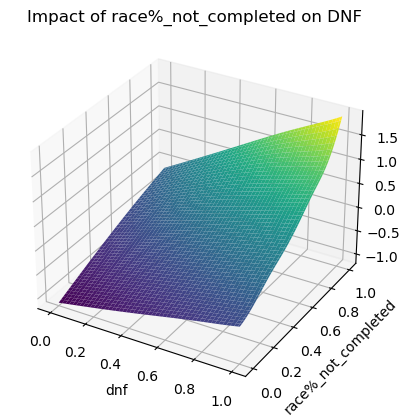

In [9]:
# interaction term between dnf and % of drivers who finished the race
XX = logistic_gam.generate_X_grid(term=3, meshgrid=True)
Z = logistic_gam.partial_dependence(term=3, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
ax=plt.title("Impact of race%_not_completed on DNF")
ax=plt.xlabel("dnf")
ax=plt.ylabel("race%_not_completed")

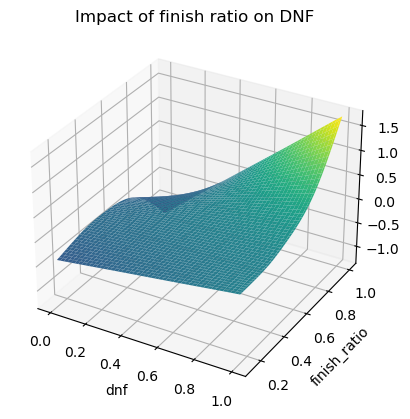

In [10]:
XX = logistic_gam.generate_X_grid(term=4, meshgrid=True)
Z = logistic_gam.partial_dependence(term=4, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
ax=plt.title("Impact of finish ratio on DNF")
ax=plt.xlabel("dnf")
ax=plt.ylabel("finish_ratio")

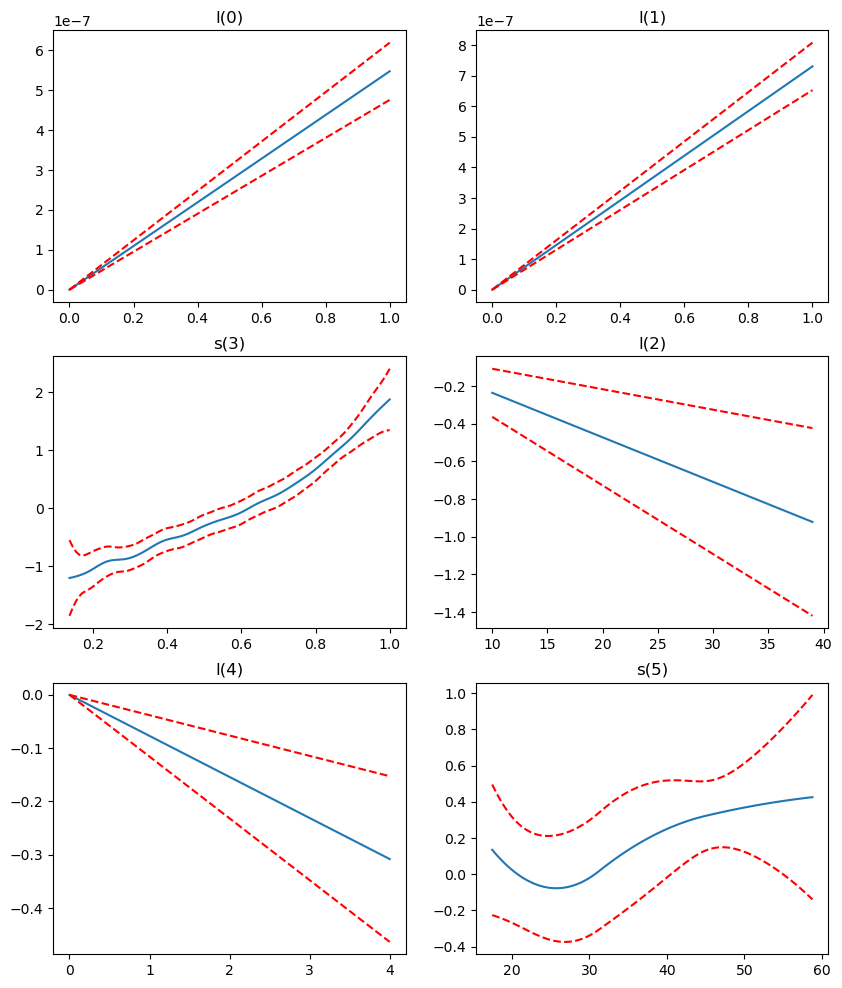

In [11]:
fig, axs=plt.subplots(3, 2, figsize=(10,12))

for i, term, x, y in zip([0, 1, 2], logistic_gam.terms[0:3], [0, 0, 1], [0, 1, 0]):
    if term.isintercept:
        continue

    XX = logistic_gam.generate_X_grid(term=i)
    pdep, confi = logistic_gam.partial_dependence(term=i, X=XX, width=0.95)

    axs[x, y].plot(XX[:, term.feature], pdep)
    axs[x, y].plot(XX[:, term.feature], confi, c='r', ls='--')
    axs[x, y].set_title(repr(term))

for i, term, x, y in zip([5, 6, 7], logistic_gam.terms[5:8], [1, 2, 2], [1, 0, 1]):
    if term.isintercept:
        continue

    XX = logistic_gam.generate_X_grid(term=i)
    pdep, confi = logistic_gam.partial_dependence(term=i, X=XX, width=0.95)

    axs[x, y].plot(XX[:, term.feature], pdep)
    axs[x, y].plot(XX[:, term.feature], confi, c='r', ls='--')
    axs[x, y].set_title(repr(term))

plt.show()

### 4.2 Tuning lambda values

One area that can be tuned in a regression model is the strength of the regularization parameter lambda. This is a tricky question in the context of this model. There is naturally a high level of multicollinearity as described previously, which necessitates the use of a larger lambda value. However, since the nature of the model does not lend itself to traditional cross-validation as the model may not contain information on drivers in the test set. Additionally, there is the question of whether cross-validation scores are even necessary; some level of overfitting can be tolerated in this model as its purpose is primarily to be descriptive rather than predictive. The model will always be retrained with new data coming in.

However, since we do want to ensure that the model's calculated rankings are not too unstable, we can use some form of temporal LOOCV to determine an optimal lambda value. 

In [ ]:
for lmbda in [0.1, 0.3, 0.6, 0.9]:
    print("Lambda=", lmbda)

    for a in [1, 3, 5, 7, 9]:
        results_lambda=results_full.loc[~((results_full['year']==2024)&(results_full['round']==a)), :]
        X_logistic_gam_lambda=results_lambda.drop([
            'year',
            'round',    
            'date',
            'race_name',
            'num_finishing_drivers',
            'dob',
            'status',
            'positionOrder',
            'position_percentile',
            'years_from_prime',
            'dnf_interaction',
            'dnf_race%_interaction',
            'dnf_finish_interaction'
        ], axis=1)
        y_logistic_gam_lambda=results_lambda['position_percentile']

        logistic_gam_terms_lambda=l(0, lam=lmbda)+s(1, n_splines=10, lam=lmbda)+s(3, n_splines=10, lam=lmbda)+te(0, 1, lam=lmbda)+te(0, 3, lam=lmbda)+s(2, n_splines=4, lam=lmbda)+s(4, n_splines=4, lam=lmbda)+s(5, n_splines=5, spline_order=2, lam=lmbda)
        
        for n in range(6, len(X_logistic_gam_lambda.columns)):
            logistic_gam_terms=logistic_gam_terms+l(n)

        logistic_gam_lambda=func.fit_model(LogisticGAM(logistic_gam_terms_lambda), X_logistic_gam_lambda, y_logistic_gam_lambda)
        print("Round excluded: ", a)

        results_lambda=results_full.loc[((results_full['year']==2024)&(results_full['round']==a)), :]
        X_logistic_gam_lambda=results_lambda.drop([
            'year',
            'round',    
            'date',
            'race_name',
            'num_finishing_drivers',
            'dob',
            'status',
            'positionOrder',
            'position_percentile',
            'years_from_prime',
            'dnf_interaction',
            'dnf_race%_interaction',
            'dnf_finish_interaction'
        ], axis=1)
        y_logistic_gam_lambda=results_lambda['position_percentile']

        func.evaluate_model(logistic_gam_lambda, 'logistic_gam', X_logistic_gam_lambda, y_logistic_gam_lambda, results_lambda)


Lambda= 0.1
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  1
Evaluation results: 
MAE: 4.74
MSE: 30.1
R-squared: 0.095
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  3
Evaluation results: 
MAE: 3.37
MSE: 17.71
R-squared: 0.41
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  5
Evaluation results: 
MAE: 3.49
MSE: 17.89
R-squared: 0.462
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  7
Evaluation results: 
MAE: 4.22
MSE: 25.9
R-squared: 0.221
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  9
Evaluation results: 
MAE: 3.0
MSE: 12.99
R-squared: 0.609
Lambda= 0.3
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  1
Evaluation results: 
MAE: 4.76
MSE: 30.16
R-squared: 0.093
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  3
Evaluation results: 
MAE: 3.38
MSE: 17.75
R-squared: 0.408
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  5
Evaluation results: 
MAE: 3.49
MSE: 17.93
R-squared: 0.461
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  7
Evaluation results: 
MAE: 4.24
MSE: 26.0
R-squared: 0.218
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  9
Evaluation results: 
MAE: 3.0
MSE: 13.1
R-squared: 0.606
Lambda= 0.6
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  1
Evaluation results: 
MAE: 4.76
MSE: 30.19
R-squared: 0.092
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  3
Evaluation results: 
MAE: 3.38
MSE: 17.76
R-squared: 0.408
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  5
Evaluation results: 
MAE: 3.5
MSE: 17.94
R-squared: 0.46
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  7
Evaluation results: 
MAE: 4.25
MSE: 26.05
R-squared: 0.216
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  9
Evaluation results: 
MAE: 3.01
MSE: 13.14
R-squared: 0.605
Lambda= 0.9
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  1
Evaluation results: 
MAE: 4.77
MSE: 30.21
R-squared: 0.091
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  3
Evaluation results: 
MAE: 3.38
MSE: 17.77
R-squared: 0.408
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  5
Evaluation results: 
MAE: 3.5
MSE: 17.95
R-squared: 0.46
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Round excluded:  7
Evaluation results: 
MAE: 4.26
MSE: 26.08
R-squared: 0.216
Fitting model...
Complete 

Round excluded:  9
Evaluation results: 
MAE: 3.01
MSE: 13.16
R-squared: 0.604


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


In [ ]:
for lmbda in [0, 0.2, 0.4, 0.6, 0.8]:
    print("lambda= ", lmbda)

    logistic_gam_terms=l(0, lam=lmbda)+s(1, n_splines=10, lam=lmbda)+s(3, n_splines=10, lam=lmbda)+te(0, 1, lam=lmbda)+te(0, 3, lam=lmbda)+s(2, n_splines=4, lam=lmbda)+s(4, n_splines=4, lam=lmbda)+s(5, n_splines=5, spline_order=2, lam=lmbda)
    # performance is worse with interaction term

    for n in range(6, len(X_logistic_gam.columns)):
        logistic_gam_terms=logistic_gam_terms+l(n)

    logistic_gam=func.fit_model(LogisticGAM(logistic_gam_terms), X_logistic_gam, y_logistic_gam)
    func.evaluate_model(logistic_gam, 'logistic_gam', X_logistic_gam, y_logistic_gam, results_predictions)

lambda=  0
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Evaluation results: 
MAE: 2.04
MSE: 6.76
R-squared: 0.876
lambda=  0.2
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Evaluation results: 
MAE: 2.04
MSE: 6.76
R-squared: 0.876
lambda=  0.4
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Evaluation results: 
MAE: 2.04
MSE: 6.76
R-squared: 0.876
lambda=  0.6
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Evaluation results: 
MAE: 2.04
MSE: 6.77
R-squared: 0.876
lambda=  0.8
Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Evaluation results: 
MAE: 2.04
MSE: 6.77
R-squared: 0.876


By our calculations, there is some practically negligible improvement in overall cross-validated scores with a lower lambda, both using a temporal LOOCV MSE and a standard MSE. Thus, some other criteria must be used to determine the optimal lambda value. For now, the pyGAM default of 0.6 is used to balance between the need to deal with multicollinearity and the danger of underfitting.

### 4.3 Competition effect

The impact of competition on driver results is another potentially important feature that has not been accounted for yet. From the rankings that have been generated later on, we can clearly see that the model views some eras as more competitive than others (most notably the modern era). We try to boost the performance of our model by feeding annual driver ratings back into the model to help account for varying grid competitiveness over time.

In [ ]:
import imp
imp.reload(func)

# adding competitiveness feature

logistic_gam_driver_score=func.get_rankings(logistic_gam, 'logistic_gam', X_logistic_gam, results_predictions, ranking='annual', min_races_season=0)
X_logistic_gam_meta=pd.merge(results_predictions, logistic_gam_driver_score, how='left', on=['driver_name', 'year'])
race_scores=X_logistic_gam_meta.groupby(['year', 'round']).agg(['median'])['score'].reset_index()
X_logistic_gam_meta=pd.merge(X_logistic_gam_meta, race_scores, how='left', on=['year', 'round'])
X_logistic_gam_meta=X_logistic_gam_meta.drop(['score'], axis=1).rename({'median':'competitiveness'}, axis=1)
X_logistic_gam_meta['competitiveness']=minmax_scale(X_logistic_gam_meta['competitiveness'])

# creating dummies for drivers and constructor-year pairs
X_logistic_gam_meta=pd.concat([X_logistic_gam_meta, pd.get_dummies(X_logistic_gam_meta['driver_name'])], axis=1).drop(['driver_name'], axis=1)
X_logistic_gam_meta=pd.concat([X_logistic_gam_meta, pd.get_dummies(X_logistic_gam_meta['constructor_year'])], axis=1).drop(['constructor_year'], axis=1)

y_logistic_gam_meta=X_logistic_gam_meta['position_percentile']

X_logistic_gam_meta=X_logistic_gam_meta.drop([
    'year',
    'round',    
    'date',
    'race_name',
    'num_finishing_drivers',
    'dob',
    'status',
    'positionOrder',
    'position_percentile',
    'years_from_prime',
    'dnf_interaction',
    'dnf_race%_interaction',
    'dnf_finish_interaction'
], axis=1)

print(X_logistic_gam_meta.columns, "\n")

# creating GAM terms
gam_terms_meta=l(0)+s(1, n_splines=10)+s(3, n_splines=10)+te(0, 1)+te(0, 3)+s(2, n_splines=4)+s(4, n_splines=4)+s(5, n_splines=5, spline_order=2)+l(6)

for n in range(7, len(X_logistic_gam_meta.columns)):
    gam_terms_meta=gam_terms_meta+l(n)

import imp
imp.reload(func)

logistic_gam_meta=func.fit_model(LogisticGAM(gam_terms_meta), X_logistic_gam_meta, y_logistic_gam_meta)
func.evaluate_model(logistic_gam_meta, 'logistic_gam_meta', X_logistic_gam_meta, y_logistic_gam_meta, results_predictions)

C:\Users\Jack Sun\AppData\Local\Temp\ipykernel_16956\1287167580.py:8: FutureWarning: ['race_name', 'driver_name', 'constructor_year', 'status'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  race_scores=X_logistic_gam_meta.groupby(['year', 'round']).agg(['median'])['score'].reset_index()


Index(['dnf', 'race%_not_completed', 'num_drivers', 'finish_ratio', 'yoe',
       'age', 'competitiveness', 'Adrian Sutil', 'Adrián Campos',
       'Aguri Suzuki',
       ...
       '2024 Alpine F1 Team', '2024 Aston Martin', '2024 Ferrari',
       '2024 Haas F1 Team', '2024 McLaren', '2024 Mercedes', '2024 RB F1 Team',
       '2024 Red Bull', '2024 Sauber', '2024 Williams'],
      dtype='object', length=1282) 

Fitting model...


C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\Jack Sun\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Complete 

Evaluation results: 
MAE: 2.04
MSE: 6.77
R-squared: 0.876


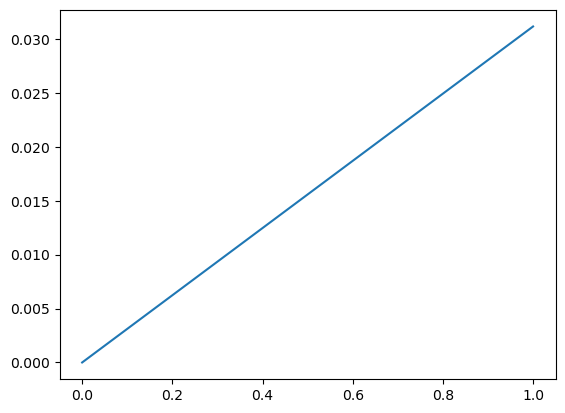

In [ ]:
XX = logistic_gam_meta.generate_X_grid(term=8)
pdep, confi = logistic_gam_meta.partial_dependence(term=8, X=XX, width=0.95)

plt.figure()
plt.plot(XX[:, l(6).feature], pdep)
plt.show()

Unfortunately, we can see that the boosted model performs practically identically to our non-boosted model, with the competitiveness feature having a very low coefficient. With more time, this feature could perhaps be explored further.

## 5. Model comparison

When the models were fitted to the data, they were assessed based primarily on MAE. However, even after we've selected a model, we must determine a methodology to actually rank drivers.

The goal of this exercise is to determine driver performance. In order to do this, we must ensure that all non-driver variables are equalized. We are effectively answering the question: "who would come out on top in a race if we put everyone in the same car with all non-driver variables controller for?" Most importantly, the constructor-year variable is zeroed out, putting the driver in a car that has no positive or negative impact on performance.

Although we still include non-driver DNF results in our training data, such results were removed from the ranking calculation. This is because would have to assume the driver did not DNF to determine their performance that race. Although we can predict with good accuracy the impact of a driver DNF, we have no way of knowing if that driver would actually have attained that position in the race, so it makes sense to exclude these results.

The model residuals are also treated quite differently. Residuals show how far off predictions are from the actual data. Although the goal is to minimize residuals, it would be close to impossible to completely eliminate them. This is because drivers (and all athletes) have swings in performance that cannot be captured by data, for example lack of motivation, lack of confidence, mental health, etc. Notable recent examples include Vettel in 2014 or Ricciardo in 2022. Thus, the residuals are kept in as a variable (we can consider it as 'driver form') with regards to determining rankings.

Once we determine performance on a race level, we determine median performance over the course of a season for each driver with at least 3 races in a single season. Median performance is chosen over average due its robustness to outliers, otherwise chance podiums for backmarkers has an outsized impact on year-to-year ratings. Although average performance is more reflective of actual driver standings, the goal of this exercise is to determine a more 'true' rating of performance. Finally, we can determine the best consecutive 3-year stretch of a driver's career, a decent enough metric that balances peak performance and career longevity.

In [12]:
import imp
imp.reload(func)

ridge_3yma_ranking=func.get_rankings(ridge, 'ridge', X_ridge, results_predictions, ranking='3yma')
ridge_annual_ranking=func.get_rankings(ridge, 'ridge', X_ridge, results_predictions, ranking='annual')
gam_3yma_ranking=func.get_rankings(gam, 'gam', X_gam, results_predictions, ranking='3yma') 
gam_annual_ranking=func.get_rankings(gam, 'gam', X_gam, results_predictions, ranking='annual') 
logistic_gam_3yma_ranking=func.get_rankings(logistic_gam, 'logistic_gam', X_logistic_gam, results_predictions, ranking='3yma') 
logistic_gam_annual_ranking=func.get_rankings(logistic_gam, 'logistic_gam', X_logistic_gam, results_predictions, ranking='annual', download=True)

Here is our comparison of the top 25 rated drivers by each model, with a focus on the last.

In [13]:
ranking_comparison=pd.concat([ridge_3yma_ranking.head(25), gam_3yma_ranking.head(25), logistic_gam_3yma_ranking.head(25)], axis=1)
ranking_comparison.columns=['ridge', 'year', 'ridge_score', 'gam', 'year', 'gam_score', 'log_gam', 'year', 'log_gam_score']
ranking_comparison

,ridge,year,ridge_score,gam,year,gam_score,log_gam,year,log_gam_score
0,Jackie Stewart,1970 - 1972,1.604,Max Verstappen,2020 - 2022,5.430,Max Verstappen,2020 - 2022,0.137
1,Niki Lauda,1976 - 1978,1.732,Lando Norris,2022 - 2024,6.167,Michael Schumacher,1994 - 1996,0.188
2,Emerson Fittipaldi,1972 - 1974,2.390,Charles Leclerc,2022 - 2024,6.520,Lewis Hamilton,2014 - 2016,0.196
3,Ayrton Senna,1989 - 1991,2.465,Fernando Alonso,2012 - 2014,6.592,Jim Clark,1963 - 1965,0.202
4,Nelson Piquet,1982 - 1984,2.466,Stirling Moss,1959 - 1961,6.674,Fernando Alonso,2005 - 2007,0.207
5,Michael Schumacher,1993 - 1995,2.479,Jackie Stewart,1971 - 1973,6.783,Stirling Moss,1958 - 1960,0.212
6,Graham Hill,1963 - 1965,2.505,Jim Clark,1962 - 1964,6.926,Jackie Stewart,1969 - 1971,0.212
7,Eddie Cheever,1981 - 1983,2.574,Jenson Button,2010 - 2012,6.996,Charles Leclerc,2022 - 2024,0.223
8,Keke Rosberg,1983 - 1985,2.641,Carlos Sainz,2022 - 2024,7.203,Lando Norris,2022 - 2024,0.233
9,Patrick Depailler,1976 - 1978,2.886,Lewis Hamilton,2012 - 2014,7.215,Alberto Ascari,1951 - 1953,0.237


Here is a ranking of the drivers for the 2024 season, updated to the 2024 Hungarian Grand Prix.

In [14]:
logistic_gam_annual_ranking.loc[logistic_gam_annual_ranking['year']==2024, :]

,driver_name,year,score
2,Max Verstappen,2024,0.137
23,Charles Leclerc,2024,0.205
29,Lando Norris,2024,0.208
135,Oscar Piastri,2024,0.281
138,Carlos Sainz,2024,0.283
158,Fernando Alonso,2024,0.292
243,Lewis Hamilton,2024,0.328
385,George Russell,2024,0.374
420,Yuki Tsunoda,2024,0.383
565,Pierre Gasly,2024,0.423


Here is a list of the top peforming driver of each year (since 2000), i.e. who the model thinks should have won the drivers' championship.

In [15]:
import imp
imp.reload(func)
func.get_rankings(logistic_gam, 'logistic_gam', X_logistic_gam, results_predictions, ranking='annual').sort_values('score').groupby('year').head(1).sort_values('year', ascending=False).head(25)

,driver_name,year,score
2,Max Verstappen,2024,0.137
4,Max Verstappen,2023,0.152
3,Max Verstappen,2022,0.146
1,Max Verstappen,2021,0.136
0,Max Verstappen,2020,0.130
37,Lewis Hamilton,2019,0.214
16,Lewis Hamilton,2018,0.196
34,Lewis Hamilton,2017,0.212
46,Lewis Hamilton,2016,0.223
13,Lewis Hamilton,2015,0.194


We can even generate rankings for constructor-years to assess which cars provided the biggest advantage to their drivers.

In [17]:
import imp
imp.reload(func)

ridge_constructor_ranking=constructor_coefficients=func.get_constructor_rankings(ridge, 'ridge', X_ridge)
gam_constructor_ranking=constructor_coefficients=func.get_constructor_rankings(gam, 'gam', X_gam)
logistic_gam_constructor_ranking=constructor_coefficients=func.get_constructor_rankings(logistic_gam, 'logistic_gam', X_logistic_gam, download=True)

In [18]:
constructor_ranking_comparison=pd.concat([ridge_constructor_ranking.head(25), gam_constructor_ranking.head(25), logistic_gam_constructor_ranking.head(25)], axis=1)
constructor_ranking_comparison.columns=['ridge', 'ridge_score', 'gam', 'gam_score', 'log_gam', 'log_gam_score']
constructor_ranking_comparison

,ridge,ridge_score,gam,gam_score,log_gam,log_gam_score
0,1989 McLaren,-5.28,2019 Mercedes,-6.33,2011 Red Bull,-1.55
1,1992 Williams,-5.25,2011 Red Bull,-6.29,2019 Mercedes,-1.35
2,2011 Red Bull,-5.11,2013 Red Bull,-5.86,2013 Red Bull,-1.33
3,1988 McLaren,-5.00,1957 BRM,-5.75,2016 Mercedes,-1.31
4,1996 Williams,-4.99,2020 Mercedes,-5.60,2023 Red Bull,-1.29
5,1991 Williams,-4.82,2016 Mercedes,-5.52,2022 Red Bull,-1.13
6,1955 Lancia,-4.76,2004 Ferrari,-5.30,2020 Mercedes,-1.13
7,1993 Williams,-4.57,2018 Mercedes,-5.29,2004 Ferrari,-1.12
8,1994 Williams,-4.56,2023 Red Bull,-5.20,2017 Mercedes,-1.11
9,1981 Brabham,-4.54,2021 Mercedes,-5.19,2015 Mercedes,-1.08


## 6. Conclusion and next steps

From our data, we can see that the model views Max Verstappen to be the best driver of all time by quite a margin, followed by other well-regarded names such as Schumacher, Hamilton, Clark, and Alonso.

Given more time, there are several additional avenues we could consider to improve the model:
* Competition effects
* Customer car effects
* Better assessment of years of experience for drivers in the early 1950s
* Consideration of weather and various track effects
* Better hyperparameter tuning